# **New section**

In [ ]:
%matplotlib inline

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-8-26 Python-3.10.12 torch-2.3.1+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 91.4MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Vehicle 1 re-identified with the following matches:
0006_c014_00022350_0.jpg: 0.9981
0612_c004_00087430_0.jpg: 0.9963
0420_c010_00064065_0.jpg: 0.9926
0192_c004_00031650_0.jpg: 0.9918
0009_c001_00067380_0.jpg: 0.9914
Top 5 similar vehicles:
0006_c014_00022350_0.jpg: 0.9981
0612_c004_00087430_0.jpg: 0.9963
0420_c010_00064065_0.jpg: 0.9926
0192_c004_00031650_0.jpg: 0.9918
0009_c001_00067380_0.jpg: 0.9914


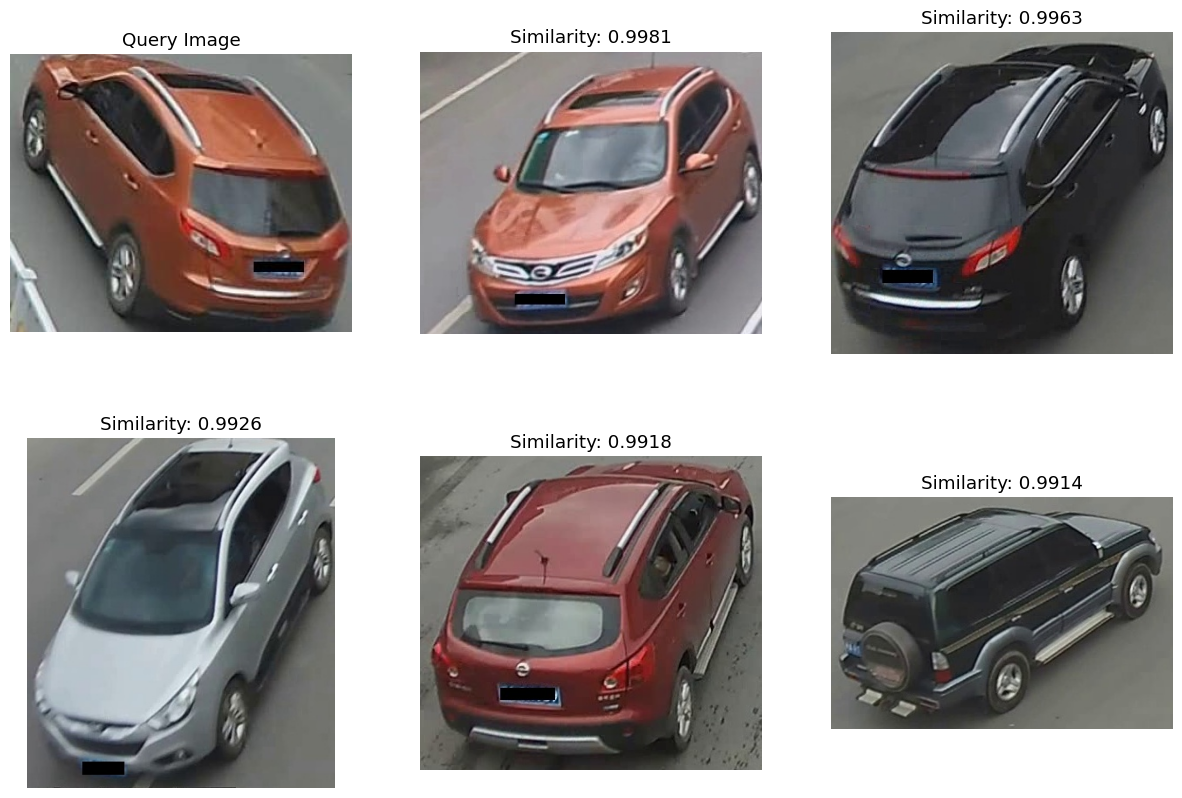

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import cv2

# Load YOLOv5 model
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Load the fine-tuned ResNet model
num_classes = 5  # Set this to the correct number of classes in your dataset
model = models.resnet50(pretrained=False)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/fine_tuned_resnet50.pth'))
model.eval()

# Preprocessing function for images
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(image_path).convert('RGB')  # Ensure image is in RGB format
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    return img_tensor

# Extract features from an image
def extract_features(image_path, model):
    img_tensor = preprocess_image(image_path)
    with torch.no_grad():
        features = model(img_tensor)
    return features.squeeze().numpy()

# Compare features using cosine similarity
def reidentify_vehicle(query_image_path, database_dir, model):
    query_features = extract_features(query_image_path, model)
    similarities = []

    for image_name in os.listdir(database_dir):
        if image_name.endswith(('.png', '.jpg', '.jpeg')):  # Filter for image files
            db_image_path = os.path.join(database_dir, image_name)
            db_features = extract_features(db_image_path, model)
            similarity = cosine_similarity([query_features], [db_features])[0][0]
            similarities.append((db_image_path, similarity))

    # Sort by similarity in descending order
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities

# Detect vehicles using YOLOv5
def detect_vehicles(image_path, yolo_model):
    results = yolo_model(image_path)
    vehicle_detections = results.pandas().xyxy[0]
    vehicle_detections = vehicle_detections[vehicle_detections['name'].isin(['car', 'truck', 'bus'])]

    return vehicle_detections

# Crop detected vehicles from the image
def crop_detections(image_path, detections):
    image = Image.open(image_path)
    vehicle_crops = []

    for _, detection in detections.iterrows():
        xmin, ymin, xmax, ymax = map(int, [detection['xmin'], detection['ymin'], detection['xmax'], detection['ymax']])
        crop = image.crop((xmin, ymin, xmax, ymax))
        vehicle_crops.append(crop)

    return vehicle_crops

# Test the re-identification system and display results
def test_reid_system(query_image_path, database_dir):
    results = reidentify_vehicle(query_image_path, database_dir, model)

    # Show the query image
    query_img = Image.open(query_image_path)
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(query_img)
    plt.title('Query Image')
    plt.axis('off')

    # Display top 5 matches
    print("Top 5 similar vehicles:")
    for i, (db_image_path, score) in enumerate(results[:5], start=2):
        matched_img = Image.open(db_image_path)
        plt.subplot(2, 3, i)
        plt.imshow(matched_img)
        plt.title(f'Similarity: {score:.4f}')
        plt.axis('off')
        print(f'{os.path.basename(db_image_path)}: {score:.4f}')

    plt.show()

# Main pipeline integrating YOLOv5 and ResNet
def pipeline(image_path, yolo_model, resnet_model, database_dir):
    # Step 1: Detect vehicles using YOLOv5
    detections = detect_vehicles(image_path, yolo_model)

    # Step 2: Crop detected vehicles
    vehicle_crops = crop_detections(image_path, detections)

    # Step 3: Re-identify each detected vehicle
    for i, crop in enumerate(vehicle_crops):
        crop_path = f'crop_{i}.jpg'
        crop.save(crop_path)  # Save cropped image for re-identification

        # Extract features and compare with database
        results = reidentify_vehicle(crop_path, database_dir, resnet_model)

        print(f"Vehicle {i+1} re-identified with the following matches:")
        for db_image_path, score in results[:5]:
            print(f'{os.path.basename(db_image_path)}: {score:.4f}')

        # Optionally display results
        test_reid_system(crop_path, database_dir)

# Example usage
if __name__ == "__main__":
    query_image_path = '/content/0006_c015_00022380_0.jpg'
    database_directory = '/content/drive/MyDrive/query'

    # Run the pipeline
    pipeline(query_image_path, yolo_model, model, database_directory)


# **New section1**

In [1]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 16923, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 16923 (delta 57), reused 73 (delta 35), pack-reused 16805 (from 1)
Receiving objects: 100% (16923/16923), 15.69 MiB | 11.33 MiB/s, done.
Resolving deltas: 100% (11595/11595), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.1/871.1 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0


In [13]:
%cd /content/yolov5
!python3 detect.py --weights /content/drive/MyDrive/best.pt --img 416 --conf 0.1 --source /content/0006_c014_00022350_0.jpg --save-txt --save-crop --project=/content/abc


/content/yolov5
detect: weights=['/content/drive/MyDrive/best.pt'], source=/content/0006_c014_00022350_0.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/abc, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-361-gc5ffbbf1 Python-3.10.12 torch-2.4.0+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/0006_c014_00022350_0.jpg: 352x416 1 SUV, 151.1ms
Speed: 1.3ms pre-process, 151.1ms inference, 1.1ms NMS per image at shape (1, 3, 416, 416)
Results saved to /content/abc/exp6
1 labels saved to /content/abc/exp6/labels


In [14]:
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-15-7eb6ef2aed08>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Re-identification results for 0006_c014_00022350_0.jpg:
0006_c014_00022350_0.jpg: 0.9962
0006_c015_00022380_0.jpg: 0.9956
0006_c015_00022385_0.jpg: 0.9781


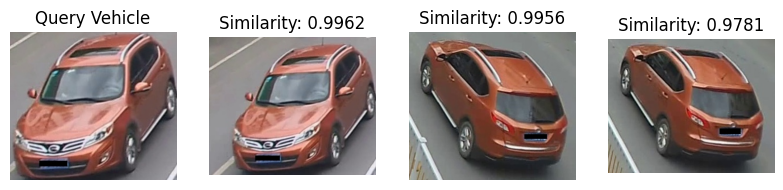

In [15]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load the fine-tuned ResNet model
num_classes = 5  # Set this to the correct number of classes in your dataset
model = models.resnet50(pretrained=False)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/fine_tuned_resnet50.pth'))
model.eval()

# Preprocessing function for images
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

# Extract features from an image
def extract_features(image_path, model):
    img_tensor = preprocess_image(image_path)
    with torch.no_grad():
        features = model(img_tensor)
    return features.squeeze().numpy()

# Compare features using cosine similarity
def reidentify_vehicle(cropped_image_path, database_dir, model):
    query_features = extract_features(cropped_image_path, model)
    similarities = []

    for image_name in os.listdir(database_dir):
        if image_name.endswith(('.png', '.jpg', '.jpeg')):
            db_image_path = os.path.join(database_dir, image_name)
            db_features = extract_features(db_image_path, model)
            similarity = cosine_similarity([query_features], [db_features])[0][0]
            similarities.append((db_image_path, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities

# Display results
def display_results(cropped_image_path, results):
    plt.figure(figsize=(15, 10))

    # Show the cropped vehicle image
    try:
        cropped_img = Image.open(cropped_image_path)
        plt.subplot(1, 6, 1)
        plt.imshow(cropped_img)
        plt.title('Query Vehicle')
        plt.axis('off')
    except Exception as e:
        print(f"Error opening cropped image: {e}")

    # Display top 5 matches
    for i, (db_image_path, score) in enumerate(results[:3], start=2):
        try:
            matched_img = Image.open(db_image_path)
            plt.subplot(1, 6, i)
            plt.imshow(matched_img)
            plt.title(f'Similarity: {score:.4f}')
            plt.axis('off')
        except Exception as e:
            print(f"Error opening matched image {db_image_path}: {e}")

    plt.show()

# Example usage
if __name__ == "__main__":
    crops_directory = '/content/abc/exp6/crops/SUV'  # Directory where cropped images are saved
    database_directory = '/content/query'  # Database of known vehicles

    for crop_file in os.listdir(crops_directory):
        crop_path = os.path.join(crops_directory, crop_file)

        # Run re-identification
        results = reidentify_vehicle(crop_path, database_directory, model)

        print(f"Re-identification results for {crop_file}:")
        for db_image_path, score in results[:3]:
            print(f'{os.path.basename(db_image_path)}: {score:.4f}')

        # Display results
        display_results(crop_path, results)
